In [206]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
from utils_segmentation import p3, q

np.random.seed(42)
import pickle
import logging
logging.basicConfig(level=logging.INFO)

In [207]:
p0 = os.path.join(q,'Meteorological','Cook','Profile')

In [208]:
z = np.array([69,90.5,112])
z_anemometer = (z+4.5)*2.54/100
z_thermistor = (z-2.5)*2.54/100

In [209]:
z_thermistor


array([1.6891, 2.2352, 2.7813])

In [210]:
files = os.listdir(p0)[:-1]

In [211]:
paths = [os.path.join(p0, f) for  f in files]

In [212]:
df_list = []
for p in paths:
    df_list.append(pd.read_excel(p,skiprows=[0,1]))

In [213]:
df = pd.concat(df_list).astype({'Timestamp':'datetime64'})

In [214]:
df.sort_values(ascending=True,by='Timestamp',inplace=True)

In [215]:
#Data collected by the ZL6 uses the UTC time for the timestamp on each saved sensor record. But it actually is PST
#df.Timestamp = df.Timestamp.dt.tz_localize('UTC')

In [216]:
df.columns = ['Timestamp', 'T2', 'T1','T0',
              'WindDirection2', 'U2','GustSpeed2', 'AnemometerT2','X_axisLevel2','Y_axisLevel2',
              'WindDirection1', 'U1','GustSpeed1', 'AnemometerT1','X_axisLevel1','Y_axisLevel1',
              'WindDirection0', 'U0','GustSpeed0', 'AnemometerT0','X_axisLevel0','Y_axisLevel0',
              'BatteryPercent', 'BatteryVoltage',
              'ReferencePressure', 'LoggerTemperature']


In [217]:
df = df[['Timestamp', 'T0', 'T1','T2', 'U0','AnemometerT0','WindDirection0','U1','AnemometerT1','WindDirection1','U2','AnemometerT2','WindDirection2']]
df['WindDirection'] = (df.WindDirection0 + df.WindDirection1 +  df.WindDirection2)/3

In [218]:
for v in ['T0', 'T1','T2','AnemometerT0','AnemometerT1','AnemometerT2']:
    #kelvin
    df[v] = df[v]+273.15

In [219]:
df.drop_duplicates(inplace=True,ignore_index=True)

In [220]:
start_time = datetime.datetime.strptime('202309251200','%Y%m%d%H%M')#.astimezone(pytz.timezone('UTC'))

In [221]:
df = df[df.Timestamp>start_time]

<AxesSubplot:xlabel='Timestamp'>

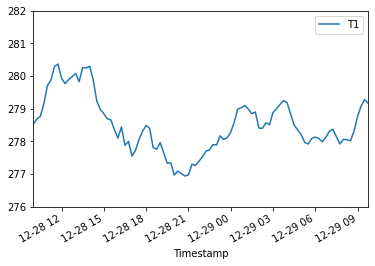

In [224]:
df.plot(x='Timestamp',y='T1',
        xlim=[df.Timestamp.values[-96],df.Timestamp.values[-1]],
        ylim=[276,282])

In [225]:
df['expU0'] = np.exp(df.U0)
df['expU1'] = np.exp(df.U1)
df['expU2'] = np.exp(df.U2)

<AxesSubplot:xlabel='Timestamp'>

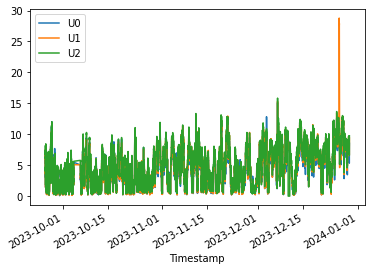

In [226]:
df.plot(x='Timestamp',y=['U0','U1','U2'])

In [227]:
u_mat = df[['U0','U1','U2']].values

In [228]:
def u_rmse(x,u,z):
    A,d,z0 = x[0],x[1],x[2] 
    return np.sqrt((u[0]-A*np.log((z[0]-d)/z0))**2+(u[0]-A*np.log((z[1]-d)/z0))**2+(u[2]-A*np.log((z[2]-d)/z0))**2)

In [229]:
from scipy import optimize

In [230]:
params = []
for i in range(u_mat.shape[0]):
    res = optimize.minimize(u_rmse,[10,.1,.1],bounds=[[0,None],[0,3],[0,3]],args=(u_mat[i,:],z_anemometer),method='Nelder-Mead',options={'maxiter':1000000,'display':True})
    params.append([*res.x,res.fun])

In [231]:
params = np.array(params)

In [232]:
df['ustar'] = 0.4*params[:,0]
df['d'] = params[:,1]
df['z0'] = params[:,2]
df['RMSE'] = params[:,3]

As the k-vanes need air flow to operate properly, only those cases are selected where
the wind speed measured at 20 m on the tower and the k-vanes at all levels is equal
to or larger than 3 m s−1. Runs with significant precipitation are also excluded, i.e. the
amount of precipitation is less than 0.1 mm, and the duration is less than 1 min per
30-min interval. Next, the routine measurements of the wind direction and temperature at 20 m and the friction velocity must be available.

<b>Wind profiles, momentum fluxes and roughness lengths
at Cabauw revisited
J. W. Verkaik and A. A. M. Holtslag</b>
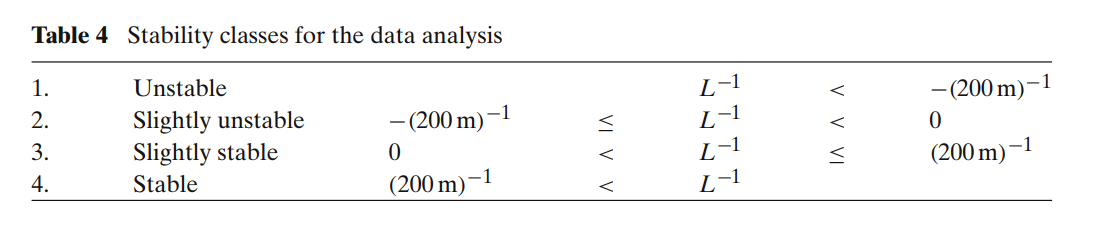

We apply the monotonic condition to the CW Historical
data set and that approximately 41% of the cases do not
meet this condition and are therefore classified as nonmonotonic profiles. When we apply the statistical method to
just the monotonic cases (approximately 59%), the resulting
mean and median z0 values are closer to those obtained with
the analytical and Charnock methods.

<b>Methods to Estimate Surface Roughness Length for Offshore
Wind Energy
Maryam Golbazi and Cristina L. Archer</b>

In [233]:
df_met = pd.read_csv('../../work/CafMeteorologyECTower/BoundsCheck/CookEast/6503_20240104_Met_P1A1.csv')
df_flux = pd.read_csv('../../work/CafMeteorologyECTower/BoundsCheck/CookEast/6503_20240104_Flux_P1A1.csv')

df_precip = df_met[['TIMESTAMP','Precipitation_Tot','amb_tmpr_Avg']]
df_precip.rename(columns={'TIMESTAMP':'Timestamp'},inplace=True)
df_precip = df_precip.astype({'Timestamp':'datetime64','amb_tmpr_Avg':'float32'})
df_precip.amb_tmpr_Avg=df_precip.amb_tmpr_Avg+273.15

df_flux = df_flux[['TIMESTAMP','air_t_mean','L']]
df_flux.rename(columns={'TIMESTAMP':'Timestamp'},inplace=True)
df_flux = df_flux.astype({'Timestamp':'datetime64'})

# df_flux.Timestamp = df_flux.Timestamp.dt.tz_localize('Etc/GMT+8')
# df_precip.Timestamp = df_precip.Timestamp.dt.tz_localize('Etc/GMT+8')

<AxesSubplot:xlabel='Timestamp'>

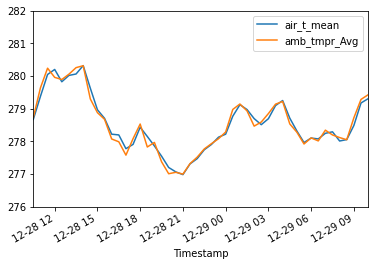

In [234]:
df_metx = pd.merge(df_flux,df_precip,how='left')
#df_metx.Timestamp = df_metx.Timestamp.dt.tz_localize('Etc/GMT+8')
#df_metx.Timestamp = df_metx.Timestamp.dt.tz_convert('UTC')
df_metx.plot(x='Timestamp',y=['air_t_mean','amb_tmpr_Avg'],
             xlim=[df_metx.Timestamp.values[-48],df_metx.Timestamp.values[-1]],
            ylim=[276,282])

In [235]:
df_valid =  pd.merge(df,df_metx)

<AxesSubplot:xlabel='Timestamp'>

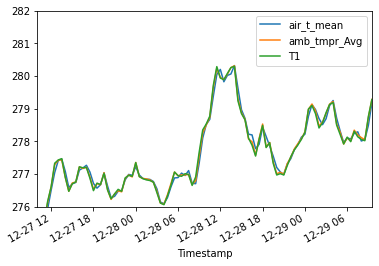

In [236]:
df_valid.plot(x='Timestamp',y=['air_t_mean','amb_tmpr_Avg','T1'],
             xlim=[df_valid.Timestamp.values[-96],df_valid.Timestamp.values[-1]],
            ylim=[276,282])

In [237]:
mask1 = df_valid.U2>df_valid.U1
mask2 = df_valid.U1>df_valid.U0
mask3 = df_valid.U0>3
mask = mask1 & mask2 & mask3
df_valid = df_valid[mask]

In [238]:
df_valid.Precipitation_Tot.interpolate(inplace=True)

In [239]:
df_valid = df_valid[df_valid.Precipitation_Tot==0]

In [240]:
df_valid = df_valid[df_valid.z0>=0.001]
df_valid = df_valid[df_valid.d>=0.001]

In [241]:
df_valid.Linv = 1/df_valid.L

In [242]:
df_valid['Stability'] = 'Stable'
mask1 = df_valid.Linv<-200
mask2 = -200<=df_valid.Linv
mask3 = df_valid.Linv<0
mask4 = 0<=1/df_valid.Linv
mask5 = df_valid.Linv<200
mask6 = 200<=df_valid.Linv

In [243]:
df_valid.loc[mask2 & mask3,'Stability']='Slightly Unstable'
df_valid.loc[mask4 & mask5,'Stability']='Slightly Stable'
df_valid.loc[mask6,'Stability']='Stable'
df_valid.loc[mask1,'Stability']='Unstable'

In [253]:
stability = pd.unique(df_valid['Stability'])

In [251]:
df_valid['Direction'] = 'ESE'
mask1 = df_valid.WindDirection<45
mask2 = df_valid.WindDirection>=0
df_valid.loc[mask1 & mask2,'Direction']='NNE'

mask1 = df_valid.WindDirection<90
mask2 = df_valid.WindDirection>=45
df_valid.loc[mask1 & mask2,'Direction']='ENE'

mask1 = df_valid.WindDirection<135
mask2 = df_valid.WindDirection>=90
df_valid.loc[mask1 & mask2,'Direction']='ESE'

mask1 = df_valid.WindDirection<180
mask2 = df_valid.WindDirection>=135
df_valid.loc[mask1 & mask2,'Direction']='SSE'

mask1 = df_valid.WindDirection<225
mask2 = df_valid.WindDirection>=180
df_valid.loc[mask1 & mask2,'Direction']='SSW'

mask1 = df_valid.WindDirection<270
mask2 = df_valid.WindDirection>=225
df_valid.loc[mask1 & mask2,'Direction']='WSW'

mask1 = df_valid.WindDirection<315
mask2 = df_valid.WindDirection>=270
df_valid.loc[mask1 & mask2,'Direction']='WNW'

mask1 = df_valid.WindDirection<360
mask2 = df_valid.WindDirection>=315
df_valid.loc[mask1 & mask2,'Direction']='NNW'

In [254]:
direction = pd.unique(df_valid['Direction'])

In [255]:
direction

array(['ESE', 'WSW', 'SSE', 'WNW', 'NNW', 'ENE', 'SSW', 'NNE'],
      dtype=object)

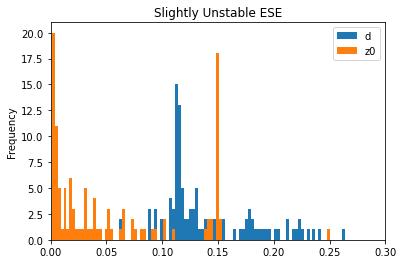

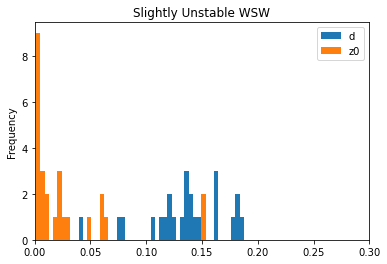

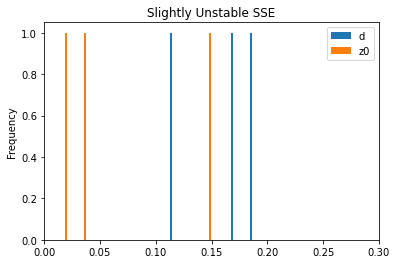

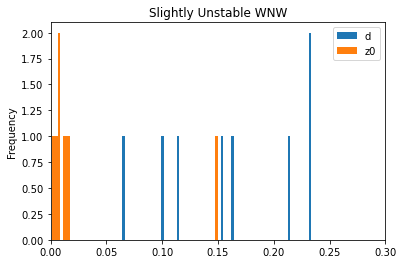

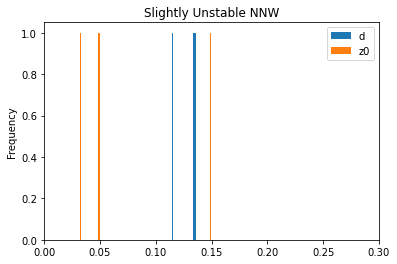

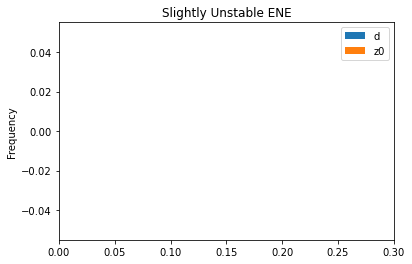

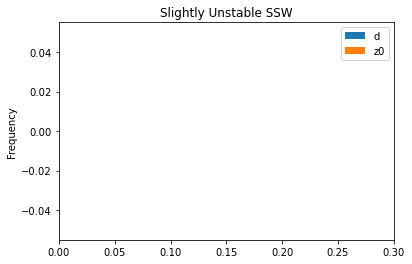

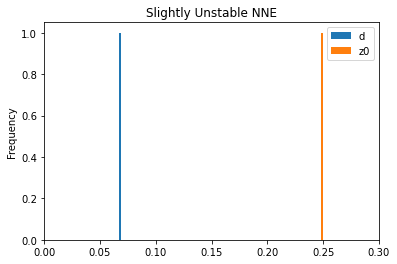

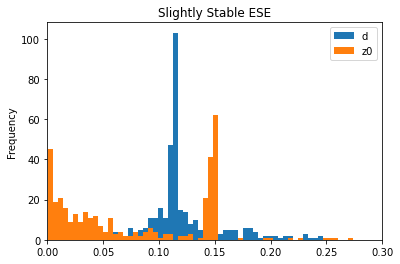

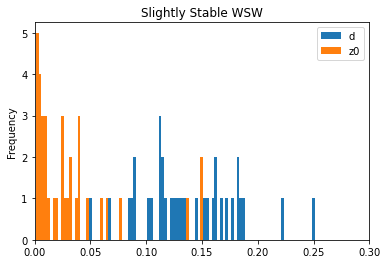

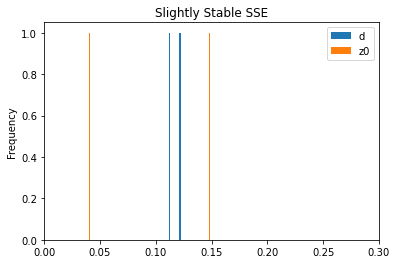

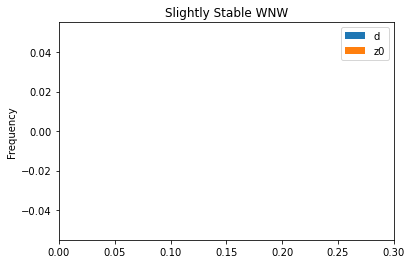

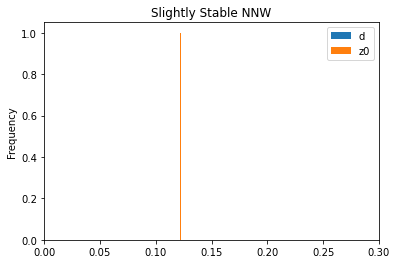

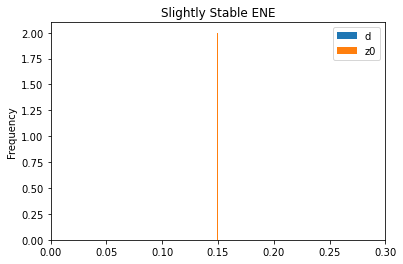

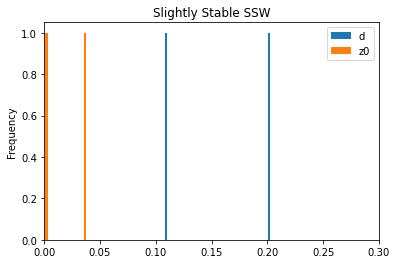

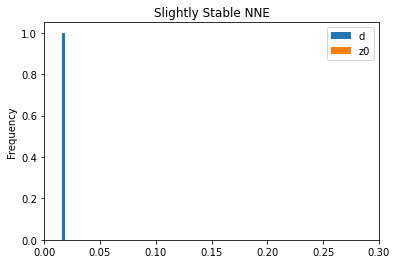

In [260]:
for stab in stability:
    for dire in direction:
        mask1 = (df_valid.Stability==stab) & (df_valid.Direction==dire)
        df_valid.loc[mask1,['d','z0']].plot.hist(bins=100,title=stab+' '+dire).set_xlim((0,0.3))